In [1]:
import sys
from pathlib import Path
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root / 'src'))

In [2]:
from riskmc.data import load_prices
from riskmc.returns import log_returns
from riskmc.simulation import mc_gaussian_returns
from riskmc.simulation import mc_student_t_returns
from riskmc.risk_metrics import var, cvar, kupiec_test
from riskmc.plots import plot_t_pnl_distribution
from riskmc.plots import plot_gaussian_pnl_distribution
from riskmc.data import create_data
from riskmc.backtest import backtest_var

In [3]:
assets = ['SPY', 'TLT', 'GLD', 'QQQ']
weights = [0.4, 0.3, 0.2, 0.1]
#weights chosen like this as
#equities (eg SPY) dominate risk
#bonds (eg TLT) as ballast
#gold (GLD) as hedge
#QQQ as growth tilt

N_SIMS = 100_000
HORIZON = 1

In [4]:
import numpy as np

In [5]:
project_root = Path('..').resolve()
data_out_path = project_root / 'data' / 'prices.csv'
create_data(data_out_path)


Saved 502 rows to /Users/ankithrangan/Desktop/Portfolio-risk-monte-carlo/data/prices.csv


Ticker,SPY,TLT,GLD,QQQ
Date,,,,
2026-01-16,691.659973,87.800003,421.290009,621.260010
2026-01-20,677.580017,86.650002,437.230011,608.059998
2026-01-21,685.400024,87.309998,443.600006,616.280029
2026-01-22,688.979980,87.690002,451.790009,620.760010
2026-01-23,689.229980,87.930000,458.000000,622.719971


In [6]:
prices = load_prices(data_out_path)
rets = log_returns(prices)

print(rets)

                 SPY       TLT       GLD       QQQ
Date                                              
2024-01-25  0.005424  0.006513  0.003962  0.001220
2024-01-26 -0.001271 -0.001917 -0.000695 -0.005975
2024-01-29  0.007888  0.011450  0.007034  0.010188
2024-01-30 -0.000774  0.009025  0.001380 -0.006679
2024-01-31 -0.016452  0.009773 -0.000743 -0.019780
...              ...       ...       ...       ...
2026-01-16 -0.000838 -0.005792 -0.004831 -0.000837
2026-01-20 -0.020567 -0.013185  0.037138 -0.021476
2026-01-21  0.011475  0.007588  0.014464  0.013428
2026-01-22  0.005210  0.004343  0.018294  0.007243
2026-01-23  0.000363  0.002733  0.013652  0.003152

[501 rows x 4 columns]


In [7]:
#use this if dataset is made larger, could be more accurate
#for now, dataset too small so use [0.4, 0.3, 0.2, 0.1]
'''
vols = rets.std()
inv_vol = 1/vols
weights = inv_vol / inv_vol
weights
'''

'\nvols = rets.std()\ninv_vol = 1/vols\nweights = inv_vol / inv_vol\nweights\n'

In [8]:
print(prices)
print(rets)

                   SPY        TLT         GLD         QQQ
Date                                                     
2024-01-24  473.680176  85.846283  186.399994  421.178345
2024-01-25  476.256439  86.407234  187.139999  421.692657
2024-01-26  475.651367  86.241714  187.009995  419.180420
2024-01-29  479.418213  87.234894  188.330002  423.472961
2024-01-30  479.047394  88.025772  188.589996  420.654114
...                ...        ...         ...         ...
2026-01-16  691.659973  87.800003  421.290009  621.260010
2026-01-20  677.580017  86.650002  437.230011  608.059998
2026-01-21  685.400024  87.309998  443.600006  616.280029
2026-01-22  688.979980  87.690002  451.790009  620.760010
2026-01-23  689.229980  87.930000  458.000000  622.719971

[502 rows x 4 columns]
                 SPY       TLT       GLD       QQQ
Date                                              
2024-01-25  0.005424  0.006513  0.003962  0.001220
2024-01-26 -0.001271 -0.001917 -0.000695 -0.005975
2024-01-29  0.0078

In [9]:
portfolio_returns = rets @ weights
print(portfolio_returns)

Date
2024-01-25    0.005038
2024-01-26   -0.001820
2024-01-29    0.009016
2024-01-30    0.002006
2024-01-31   -0.005776
                ...   
2026-01-16   -0.003123
2026-01-20   -0.006902
2026-01-21    0.011102
2026-01-22    0.007770
2026-01-23    0.004011
Length: 501, dtype: float64


In [10]:
#monte carlo sim: gaussian
sim_gaussian_asset_returns = mc_gaussian_returns(rets, N_SIMS, HORIZON)
sim_gaussian_port_returns = sim_gaussian_asset_returns @ weights

#monte carlo sim: student-t
sim_t_asset_returns = mc_student_t_returns(rets, N_SIMS, HORIZON, nu=5)
sim_t_port_returns = sim_t_asset_returns @ weights


#returns: gaussian
print(sim_gaussian_asset_returns)
print(sim_gaussian_port_returns)

[[-3.82946630e-04  3.86308905e-03 -1.30819493e-02 -4.37233029e-03]
 [ 2.01697551e-02  5.07076171e-05 -1.07966940e-02  2.72191382e-02]
 [ 2.46129886e-03  5.44534637e-03 -1.05461425e-02 -2.40433303e-04]
 ...
 [ 4.81472551e-03 -2.64860600e-03 -8.71841324e-03  7.22090364e-03]
 [ 1.04777124e-02 -7.57629946e-03  1.49435722e-02  1.65344603e-02]
 [-7.76992954e-03  8.38049985e-04  2.45607834e-02 -1.68179959e-02]]
[-0.00204787  0.00864569  0.00048485 ...  0.00010972  0.00656036
  0.0003738 ]


In [11]:
#risk metrics: gaussian
var_gaussian_95 = var(sim_gaussian_port_returns, 0.95)
var_gaussian_99 = var(sim_gaussian_port_returns, 0.99)
cvar_gaussian_95 = cvar(sim_gaussian_port_returns, 0.95)
cvar_gaussian_99 = cvar(sim_gaussian_port_returns, 0.99)

var_gaussian_95, var_gaussian_99, cvar_gaussian_95, cvar_gaussian_99

(np.float64(0.01109087426456086),
 np.float64(0.015569537641249376),
 np.float64(0.01383805457640834),
 np.float64(0.017902504494693466))

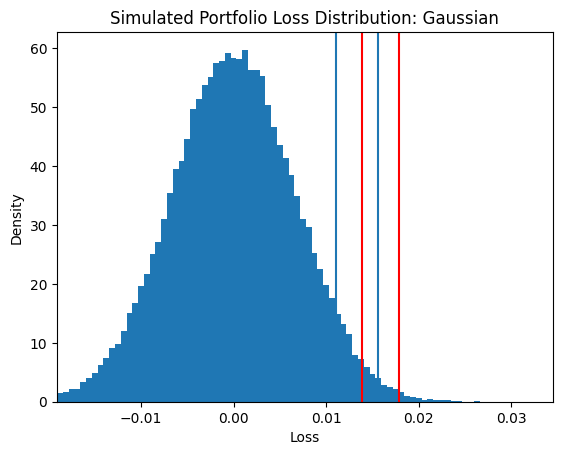

In [12]:
#plot: gaussian
plot_gaussian_pnl_distribution(sim_gaussian_port_returns, sim_t_port_returns, var_gaussian_95, var_gaussian_99, cvar_gaussian_95, cvar_gaussian_99)

In [13]:
print(np.std(sim_gaussian_port_returns))
print(np.mean(sim_gaussian_port_returns))

0.006725159522789014
-7.893763871031599e-06


In [14]:
#returns: student-t
print(sim_t_asset_returns)
print(sim_t_port_returns)

[[-2.45913639e-04  2.48072763e-03 -8.40072611e-03 -2.80774282e-03]
 [ 3.88093017e-02  9.75682252e-05 -2.07742807e-02  5.23732559e-02]
 [ 2.37276691e-03  5.24947942e-03 -1.01668020e-02 -2.31785013e-04]
 ...
 [ 3.97748779e-03 -2.18803709e-03 -7.20235912e-03  5.96525304e-03]
 [ 1.13068483e-02 -8.17583703e-03  1.61261064e-02  1.78428867e-02]
 [-1.35846218e-02  1.46521175e-03  4.29410525e-02 -2.94038848e-02]]
[-1.31506667e-03  1.66354606e-02  4.67411697e-04 ...  9.06374680e-05
  7.07949816e-03  6.53536841e-04]


In [15]:
#risk metrics: student-t
#here difference between VaR and CVaR is a lot more noticeabe
var_t_95 = var(sim_t_port_returns, 0.95)
var_t_99 = var(sim_t_port_returns, 0.99)
cvar_t_95 = cvar(sim_t_port_returns, 0.95)
cvar_t_99 = cvar(sim_t_port_returns, 0.99)

var_t_95, var_t_99, cvar_t_95, cvar_t_99

(np.float64(0.013583859948422611),
 np.float64(0.022697093676995114),
 np.float64(0.01956141366261547),
 np.float64(0.03040326526983482))

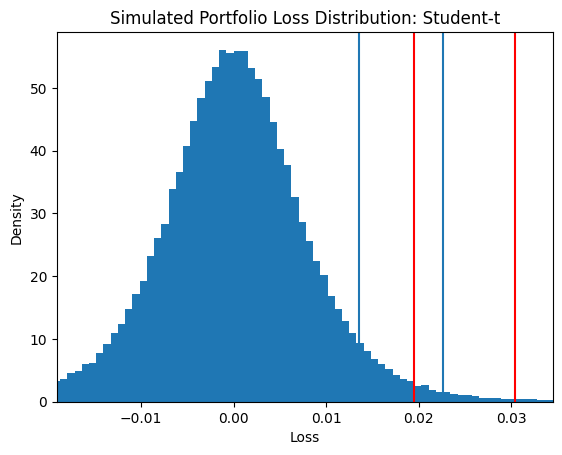

In [16]:
plot_t_pnl_distribution(sim_t_port_returns, sim_gaussian_port_returns, var_t_95, var_t_99, cvar_t_95, cvar_t_99)

In [17]:
#student-t plot has fatter tails, hence larger separation between VaR and CVaR

In [18]:
print(np.std(sim_t_port_returns))
print(np.mean(sim_t_port_returns))

0.00870167777107107
-1.9636278233090447e-05


In [19]:
#Backtesting

In [20]:
var_level = 0.99

breaches_gaussian, _ = backtest_var(rets, weights=weights, var_level=var_level, model='gaussian')
breaches_t, _ = backtest_var(rets, weights=weights, var_level=var_level, model='student-t')

In [25]:
#check gaussian breach rate
gaussian_empirical_rate = breaches_gaussian.mean()
gaussian_expected_rate = 1 - var_level

print(f'expected breach rate: {gaussian_expected_rate}')
print(f'empirical breach rate: {gaussian_empirical_rate}')

#kupiec test
gau_kup_LR, gau_kup_pval = kupiec_test(breaches_gaussian, var_level)
print(gau_kup_pval)

if gau_kup_pval < 0.05:
    print(f'as kupiec p-value = {gau_kup_pval} << 0.05, seeing breach results this extreme would only happen 0.8% of the time, which is too unlikely under the null (the null being the returns distribution is Gaussian)')
    print('this suggests gaussian model has under-coverage (breaches occur too often relative to 1%), tail risk is underestimated, model fails backtest diagnostics')

expected breach rate: 0.010000000000000009
empirical breach rate: 0.025
0.007887219163010939
as kupiec p-value = 0.007887219163010939 << 0.05, seeing breach results this extreme would only happen 0.8% of the time, which is too unlikely under the null (the null being the returns distribution is Gaussian)
this suggests gaussian model has under-coverage (breaches occur too often relative to 1%), tail risk is underestimated, model fails backtest diagnostics


In [26]:
#check student-t breach rate
t_empirical_rate = breaches_t.mean()
t_expected_rate = 1 - var_level

print(f'expected breach rate: {t_expected_rate}')
print(f'empirical breach rate: {t_empirical_rate}')

#kupiec test
t_kup_LR, t_kup_pval = kupiec_test(breaches_t, var_level)
print(t_kup_pval)

if t_kup_pval < 0.05:
    print(f'as kupiec p-value = {t_kup_pval} << 0.05, seeing breach results this extreme would only happen 0.8% of the time, which is too unlikely under the null')
    print('this suggests gaussian model has under-coverage (breaches occur too often relative to 1%), tail risk is underestimated, model fails backtest diagnostics')
else:
    print(f'as kupiec p-value = {t_kup_pval} >> 0.05, the breach results we see are acceptable under the null (the null being the returns distribution is student-t)')
    print(f'Student-t VaR passes unconditional coverage tests (Kupiec p = 0.48), indicating statistically consistent tail-risk estimates.”')

expected breach rate: 0.010000000000000009
empirical breach rate: 0.006818181818181818
0.47663998336827795
as kupiec p-value = 0.47663998336827795 >> 0.05, the breach results we see are acceptable under the null (the null being the returns distribution is student-t)
Student-t VaR passes unconditional coverage tests (Kupiec p = 0.48), indicating statistically consistent tail-risk estimates.”


In [ ]:
#Student-t VaR passes unconditional coverage tests (Kupiec p = 0.48), indicating statistically consistent tail-risk estimates.”